In [1]:
import numpy as np
import pandas as pd
import biogeme
import sklearn
from lightgbm import LGBMClassifier

In [2]:
ned_data_rp = pd.read_table("Data/netherlandsRP.dat")
ned_data = pd.read_table("Data/netherlands.dat")

In [3]:
ned_data['choice'] = ned_data.choice.replace(to_replace=[10, 11], value=[0, 1])

In [4]:
ned_data.columns

Index(['id', 'rp', 'sp', 'choice', 'purpose', 'npersons', 'age',
       'employ_status', 'mainearn', 'arrival_time', 'gender', 'rail_ivtt',
       'rail_cost', 'rail_transfers', 'rail_acc_time', 'rail_egr_time',
       'rail_acc_mode', 'rail_egr_mode', 'seat_status', 'car_ivtt', 'car_cost',
       'car_walk_time', 'car_parking_fee', 'rail_comfort', 'rp_transfer',
       'rp_choice', 'rp_rail_ovt', 'rp_car_ovt'],
      dtype='object')

In [5]:
X = ned_data[['car_cost', 'rail_cost', 'car_ivtt', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time']]
X_updt = X.copy()
X_updt['cost_dif'] = X['car_cost']-X['rail_cost']
X_updt['tt_dif'] = X['car_ivtt']- X['rail_ivtt'] -X['rail_acc_time'] -X['rail_egr_time']
X_updt = X_updt.drop(columns=['car_cost', 'rail_cost', 'car_ivtt', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time'])

y = ned_data['choice']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_updt, y, test_size=0.20, random_state=1)

In [7]:
lightGBM = LGBMClassifier(n_estimators = 20, 
                          max_depth = 10, 
                          num_leaves = 20, 
                          reg_alpha = 0.3)
                          #monotone_constraints = [1, 1])

In [8]:
eval_set = [(X_validate, y_validate)]
lightGBM.fit(X_train, y_train, eval_set=eval_set)

[1]	valid_0's binary_logloss: 0.562676
[2]	valid_0's binary_logloss: 0.556184
[3]	valid_0's binary_logloss: 0.552057
[4]	valid_0's binary_logloss: 0.547785
[5]	valid_0's binary_logloss: 0.544925
[6]	valid_0's binary_logloss: 0.541347
[7]	valid_0's binary_logloss: 0.539972
[8]	valid_0's binary_logloss: 0.537727
[9]	valid_0's binary_logloss: 0.535971
[10]	valid_0's binary_logloss: 0.535944
[11]	valid_0's binary_logloss: 0.53482
[12]	valid_0's binary_logloss: 0.533888
[13]	valid_0's binary_logloss: 0.5324
[14]	valid_0's binary_logloss: 0.53251
[15]	valid_0's binary_logloss: 0.53134
[16]	valid_0's binary_logloss: 0.531654
[17]	valid_0's binary_logloss: 0.53172
[18]	valid_0's binary_logloss: 0.532104
[19]	valid_0's binary_logloss: 0.531599
[20]	valid_0's binary_logloss: 0.531197


LGBMClassifier(max_depth=10, n_estimators=20, num_leaves=20, reg_alpha=0.3)

In [9]:
y_pred=lightGBM.predict(X_validate)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
accuracy_score(y_validate, y_pred)

0.7672413793103449

In [12]:
import biogeme.database as db
train_data = X.join(y)
database = db.Database("ned_data", train_data)
globals().update(database.variables)

In [13]:
from biogeme.expressions import Beta, Variable

ASC_c = Beta('ASC_c',0,None,None,0)
ASC_pt = Beta('ASC_pt', 0,None,None,1)

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)


In [14]:
V_c = ASC_c + B_COST * car_cost/100 + B_TIME * car_ivtt
V_pt = ASC_pt + B_COST * rail_cost/100 + B_TIME * (rail_ivtt + rail_acc_time + rail_egr_time)
V = {0: V_c, 1: V_pt}

In [15]:
avail = {0: 1, 1: 1}

In [16]:
import biogeme.models as models

import biogeme.messaging as msg
import biogeme.biogeme as bio

# observation to the log likelihood function.
logprob = models.loglogit(V, None, choice)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = '01logit'

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(avail)

# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
print(pandasResults)


           Value   Std err    t-test       p-value  Rob. Std err  Rob. t-test  \
ASC_c   0.582154  0.107471  5.416867  6.065252e-08      0.108929     5.344339   
B_COST -1.247564  0.313320 -3.981753  6.840885e-05      0.340191    -3.667243   
B_TIME  0.136640  0.058899  2.319887  2.034701e-02      0.057360     2.382127   

        Rob. p-value  
ASC_c   9.074776e-08  
B_COST  2.451802e-04  
B_TIME  1.721294e-02  


In [17]:
x_line = np.arange(-4, 4, 0.1)
B = -pandasResults.loc['B_TIME', 'Value'] / pandasResults.loc['B_COST', 'Value']
C = -pandasResults.loc['ASC_c', 'Value']/ pandasResults.loc['B_COST', 'Value']
y_line = B*x_line + C

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-80.0, 80.0)

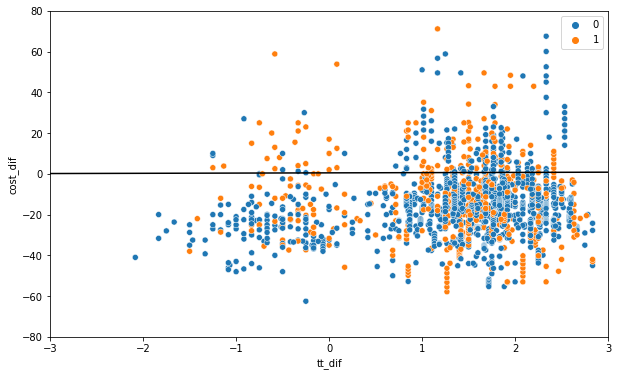

In [19]:
plt.figure(figsize=(10, 6))

data_plot = X_updt.join(y)

sns.scatterplot(x='tt_dif', y='cost_dif', hue='choice', data= data_plot)
sns.lineplot(x_line, y_line, color='k')
plt.xlim([-3, 3])
plt.ylim([-80, 80])

In [20]:
x_search = np.arange(-6, 6.1, 0.1)
y_search = np.arange(-160, 162, 2)

In [21]:
feature_like = []
for i in x_search:
    for j in y_search:
        
        feature_like.append([i, j])

In [22]:
data = lightGBM.predict_proba(feature_like)

In [23]:
data_inter = data[:, 0].reshape((len(x_search), len(y_search)))

In [24]:
from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((x_search, y_search), data_inter, bounds_error=False)

In [25]:
def fs(x):
    return np.squeeze([interp([x[0], x[1]]) - 0.5, interp([x[0], x[1]]) - 0.5])

In [26]:
from scipy.optimize import fsolve
from numpy.random import rand, seed

seed(1)

x_random = (rand(10000) - 0.5)*6
y_random = (rand(10000) - 0.5)*160

roots = np.array([fsolve(fs, [i, j]) for i,j in zip(x_random, y_random)])


C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [27]:
mask = (interp(roots) == 0.5)

In [28]:
roots_fined = roots[mask]

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-80.0, 80.0)

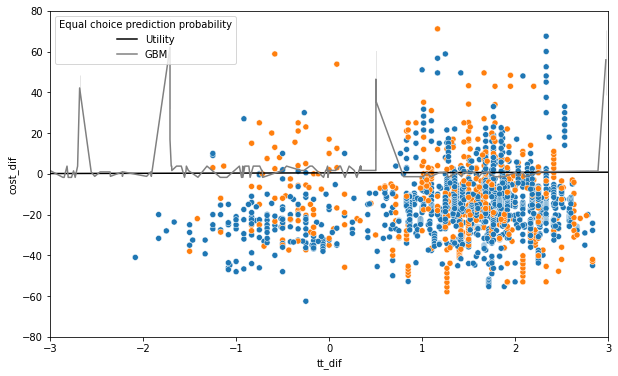

In [35]:
plt.figure(figsize=(10, 6))

data_plot = X_updt.join(y)

sns.scatterplot(x='tt_dif', y='cost_dif', hue='choice', data= data_plot)
#plt.legend(title='Choice', loc='upper left', labels=['Car', 'Rail'])
sns.lineplot(x_line, y_line, color='k')
sns.lineplot(roots_fined[:, 0], roots_fined[:, 1], color = 'gray')
plt.legend(title='Equal choice prediction probability', loc='upper left', labels=['Utility', 'GBM'])
plt.xlim([-3, 3])
plt.ylim([-80, 80])